##데이터 불러오기

In [1]:
#데이터 불러오기

import pandas as pd
import urllib.request
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

data = pd.read_csv('capterra_2018.csv', encoding="ISO-8859-1", error_bad_lines=False)
print('pros review 개수 :',len(data))# null값으로 인식되어 1041443개로 인식


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (0,1,2,3,4,11,12,13,14,15,16) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


pros review 개수 : 1041443


##데이터 전처리

In [2]:
#null 값 제거 후 prosText column만 사용(LDA에서는 data type이 list인 것이 코드 활용하는데 있어 편리함 )
text_data = data["prosText"].dropna(axis=0)# prosText에 있는 null값 제거
print(text_data)

0       Microsoft is excellent in its support for offi...
1       The Business App world can be confusing. I get...
2       Accessibility is the biggest asset of Office 3...
3       With nearly 25 years in the Windows universe, ...
4       Office 365 is a very complete software package...
                              ...                        
2163    Office 365 keeps me up-to-date with the newest...
2164    The first thing is how easy you can edit/write...
2165    With the Lync program I can keep in touch with...
2166    Office 365 is one of the classic in terms of o...
2167    Still the best office software. Nothing works ...
Name: prosText, Length: 2168, dtype: object


In [3]:
#문서를 소문자로 변환 후 토큰화 및 특수문자 및 공백숫자 제거(의미있는 단어만 남김)
tokenized_text = []
for doc in text_data:
    tokenized_text.append(nltk.regexp_tokenize(doc.lower(), '[A-Za-z]+'))   

In [4]:
print(tokenized_text)

[['microsoft', 'is', 'excellent', 'in', 'its', 'support', 'for', 'office', 'and', 'whenever', 'i', 'have', 'needs', 'to', 'call', 'on', 'them', 'they', 'have', 'always', 'responded', 'and', 'even', 'for', 'clients', 'i', 'cannot', 'go', 'to', 'the', 'support', 'from', 'microsoft', 'sometimes', 'mean', 'that', 'my', 'input', 'is', 'not', 'even', 'needed', 'to', 'overcome', 'their', 'complaints', 'there', 'is', 'a', 'staggering', 'volume', 'of', 'effective', 'updates', 'for', 'office', 'i', 'recall', 'having', 'an', 'issue', 'with', 'outlook', 'on', 'a', 'client', 's', 'platform', 'that', 'resulted', 'in', 'a', 'system', 'crash', 'whenever', 'he', 'tries', 'to', 'access', 'it', 'he', 'called', 'me', 'and', 'complained', 'and', 'i', 'was', 'supposed', 'to', 'go', 'fix', 'it', 'by', 'the', 'weekend', 'incidentally', 'an', 'update', 'was', 'released', 'that', 'same', 'day', 'and', 'by', 'the', 'time', 'he', 'installed', 'the', 'new', 'update', 'that', 'issue', 'was', 'magically', 'solved', 

In [14]:
#토큰화된 문서에 불용어 사전 적용 & 표제어 추출 + 추가적인 불용어 처리 가능
from nltk.corpus import stopwords
from nltk.corpus import wordnet
import nltk
from nltk import pos_tag

#nltk download pakage
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')

#불용어 사전 적용
def apply_stop_words(tokenized_text):
    stop_words = stopwords.words('english') 
    stop_words.extend(["with","nearly"]) ## 추가적으로 빼고싶은 단어 추가가능
    result = []
    for tok_list in tokenized_text:
        tok_result =[]
        for tok in tok_list:
            if tok not in stop_words:
              tok_result.append(tok)
        result.append(tok_result)
    return result

# 표제어 추출 (pos 태깅 후 사용가능)

# pos 태깅 분류(LDA topic으로 주로 사용되는 형용사, 동사, 명사, 부사,만 태깅해서 사용 )
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    
    elif tag.startswith('V'):
        return wordnet.VERB
    
    elif tag.startswith('N'):
        return wordnet.NOUN
    
    elif tag.startswith('R'):
        return wordnet.ADV
    
    else:
        return None
        
 #표제어 추출 적용
def apply_lemma(tokenized_text):
    lemma = WordNetLemmatizer()
    result = []
    for tok_list in tokenized_text:
        tok_result =[lemma.lemmatize(tok[0], pos= get_wordnet_pos(tok[1])) for tok in tok_list]
        tok_result_set = []
        for tok in tok_result:
          if len(tok) > 3: # 글자의 수가 3이상인 것들만 저장
            tok_result_set.append(tok)
        result.append(tok_result_set)
    return result

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [16]:
#불용어사전 및 품사 태깅한 표제어 추출 적용하여 전처리 및 토큰화가 완료된 document 생성
result_stopword = apply_stop_words(tokenized_text)
result_tagging = [pos_tag(tok) for tok in result_stopword]
result_tagging_alpha =[]
for l in result_tagging:
    s= [tagged_word for tagged_word in l if tagged_word[1].startswith(('J', 'V', 'N', 'R'))]
    result_tagging_alpha.append(s)

tokenized_doc = apply_lemma(result_tagging_alpha)
print(tokenized_doc)

[['microsoft', 'excellent', 'support', 'office', 'need', 'call', 'always', 'respond', 'even', 'client', 'cannot', 'support', 'microsoft', 'sometimes', 'mean', 'input', 'even', 'need', 'overcome', 'complaint', 'stagger', 'volume', 'effective', 'updates', 'office', 'recall', 'issue', 'outlook', 'client', 'platform', 'result', 'system', 'crash', 'access', 'call', 'complain', 'suppose', 'weekend', 'incidentally', 'update', 'release', 'time', 'instal', 'update', 'issue', 'magically', 'solve', 'thus', 'save', 'stress', 'embark', 'trip', 'never', 'forget', 'already', 'hectic', 'period', 'secure', 'onedrive', 'storage', 'come', 'business', 'version', 'client', 'appreciate', 'save', 'cost', 'additional', 'cloud', 'storage', 'vendor', 'accessibility', 'line', 'duty', 'ability', 'access', 'word', 'excel', 'power', 'point', 'skype', 'outlook', 'find', 'office', 'domicile', 'cloud', 'anywhere', 'give', 'confidence', 'take', 'many', 'task', 'collaboration', 'tool', 'sharepoint', 'microsoft', 'team',

##Coherence 와 Perplexity를 통한 LDA 토픽 수 결정

In [ ]:
#gensim을 사용하여 dictionary와 corpus 생성
from gensim import corpora 

dictionary = corpora.Dictionary(tokenized_doc)
dictionary.filter_extremes(no_below=3, no_above=0.05) #dictionary filter참고 (https://tedboy.github.io/nlps/generated/generated/gensim.corpora.Dictionary.filter_extremes.html)
corpus = [dictionary.doc2bow(text) for text in tokenized_doc]
print('Number of unique tokens: %d' % len(dictionary)) 
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 1205
Number of documents: 2168


In [ ]:
#Coherence plot(파라미터 바꿔가며 plot 확인가능)
from gensim.models.ldamodel import LdaModel 
from gensim.models.coherencemodel import CoherenceModel 
from gensim.models.callbacks import CoherenceMetric 
import matplotlib.pyplot as plt 
import numpy as np

def coherence_optimal_number_of_topics(dictionary, corpus, processed_data): 
    passes = 10
    iterations = 100
    limit = 30; #토픽 마지막갯수
    start = 10; #토픽 시작갯수
    step = 2; 
    coherence_values = []
    for num_topics in range(start, limit, step):
        lda_model = LdaModel(corpus, id2word=dictionary, num_topics=num_topics, passes=passes, iterations= iterations, random_state=1004)
        cm = CoherenceModel(model= lda_model, corpus = corpus, coherence= 'u_mass')
        coherence_values.append(cm.get_coherence())
           
    x = range(start, limit, step) 
    plt.plot(x, coherence_values) 
    plt.xlabel("Num Topics") 
    plt.ylabel("Coherence")
    plt.show() 

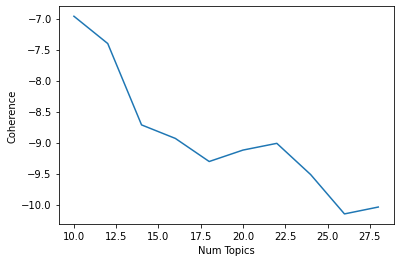

In [ ]:
coherence_optimal_number_of_topics(dictionary, corpus, tokenized_doc)

In [ ]:
#Perplexity plot(파라미터 바꿔가며 plot 확인가능)
from gensim.models.callbacks import PerplexityMetric 
from gensim.models.ldamodel import LdaModel 
import matplotlib.pyplot as plt 
import numpy as np
def perplexity_optimal_number_of_topics(dictionary, corpus, processed_data):
    passes = 10
    iterations = 100 
    limit = 30; #토픽 마지막갯수
    start = 10; #토픽 시작갯수
    step = 2; 
    perplexity_values = []
    for num_topics in range(start, limit, step):
        lda_model = LdaModel(corpus, id2word=dictionary, num_topics=num_topics, passes=passes, iterations= iterations, random_state = 1004)
        perplexity_values.append(lda_model.log_perplexity(corpus))
        
    x = range(start, limit, step) 
    plt.plot(x, perplexity_values) 
    plt.xlabel("Num Topics") 
    plt.ylabel("Perplexity")
    plt.show() 

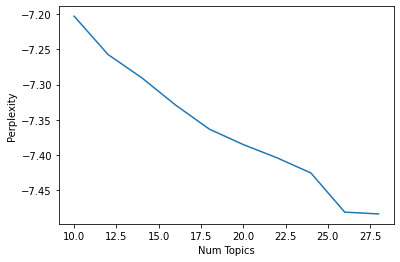

In [ ]:
perplexity_optimal_number_of_topics(dictionary, corpus, tokenized_doc)

##적정 Passes 찾기

In [ ]:
# 적정 passes 찾기
num_topics = 20
iterations = 100
coherences=[]
perplexities=[]
passes=[]
for p in range(10,110,10):
    passes.append(p) 
    lda = LdaModel(corpus, id2word=dictionary, num_topics=num_topics, iterations=iterations, passes=p)
    cm = CoherenceModel(model=lda, corpus=corpus, coherence='u_mass')
    coherence = cm.get_coherence()
    print("Cpherence",coherence)
    coherences.append(coherence)
    print('Perplexity: ', lda.log_perplexity(corpus),'\n\n')
    perplexities.append(lda.log_perplexity(corpus))

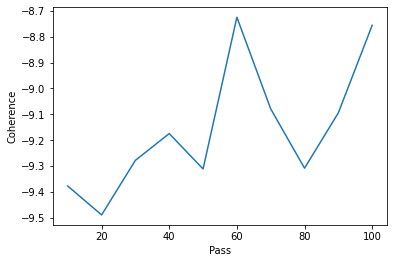

In [ ]:
x = range(10,110,10)
plt.plot(x,coherences)
plt.xlabel("Pass") 
plt.ylabel("Coherence")
plt.show() 


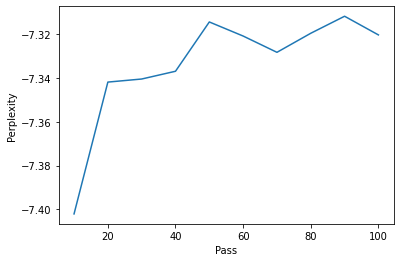

In [ ]:
x = range(10,110,10)
plt.plot(x,perplexities)
plt.xlabel("Pass") 
plt.ylabel("Perplexity")
plt.show() 

##LDA 구현

In [ ]:
#LDA 구현 후 table 만들기(파라미터 바꿔가며 사용가능)
import gensim
import re
nltk.download('punkt')

num_topic = 20 #토픽 수 지정
passes = 30
iterations = 100
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = num_topic, id2word=dictionary, iterations= iterations, passes = passes, random_state = 1004 ) 

def make_topic_table(document_text, ldamodel, num_topic, num_word): #함수적용할때 num_topic의 수가 같아야함
    topics = ldamodel.print_topics(num_topics= num_topic, num_words= num_word)
    df_topic = pd.DataFrame(topics)
    #topic 단어들 전처리
    tokenized_topic = [nltk.word_tokenize(doc.lower()) for doc in df_topic[1]]
    clean_topics= []
    for word in tokenized_topic:
        list_par = []
        for i in word:
            text = re.sub('[^a-zA-Z]',' ',i).strip() # 영어제외 다 제거.
            if(text != ''): # 영어,숫자 및 공백 제거.
                list_par.append(text)
        clean_topics.append(list_par)
    df_topic.columns = ['토픽번호', '각 키워드별 비중'] 
    df_topic["Keywords"] =clean_topics
    

    topictable = pd.DataFrame()
    for i, topic_list in enumerate(ldamodel[corpus]):
        doc = topic_list[0] if ldamodel.per_word_topics else topic_list            
        doc = sorted(doc, key=lambda x: (x[1]), reverse=True)

        # 모든 문서에 대해서 각각 아래를 수행
        for j, (topic_num, prop_topic) in enumerate(doc): #  몇 번 토픽인지와 비중을 나눠서 저장한다.
               if j == 0:  # 정렬을 한 상태이므로 가장 앞에 있는 것이 가장 비중이 높은 토픽
                   topictable = topictable.append(pd.Series([int(topic_num), round(prop_topic,10), topic_list]), ignore_index=True)
                # 가장 비중이 높은 토픽과, 가장 비중이 높은 토픽의 비중과, 전체 토픽의 비중을 저장한다.
               else:
                   break


    #전처리
    #result_table = topictable.drop([2],axis=1) #원래있던 학률*topic 제거
    result_table = topictable.reset_index() # 문서 번호을 의미하는 열(column)로 사용하기 위해서 인덱스 열을 하나 더 만든다.
    result_table.columns = ['문서번호', '가장 비중이 높은 토픽', '가장 높은 토픽의 비중',"각 토픽의 비중"] #인덱스열 name 지정
    table = result_table.join(df_topic["각 키워드별 비중"], on ="가장 비중이 높은 토픽")
    table = table.join(df_topic["Keywords"], on ="가장 비중이 높은 토픽") #topic에 따라 keywords 할당
    table["Text"] = document_text
    
    return table



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(El

In [ ]:
make_topic_table(text_data, ldamodel, 20, 20)

,문서번호,가장 비중이 높은 토픽,가장 높은 토픽의 비중,각 토픽의 비중,각 키워드별 비중,Keywords,Text
0,0,17.0,0.232086,"[(0, 0.021325203), (1, 0.033544935), (4, 0.029...","0.052*""storage"" + 0.036*""onedrive"" + 0.029*""wo...","[storage, onedrive, world, tb, skype, send, wo...",Microsoft is excellent in its support for offi...
1,1,14.0,0.445316,"[(0, 0.095296144), (1, 0.0330107), (7, 0.04756...","0.049*""give"" + 0.033*""collaborate"" + 0.033*""co...","[give, collaborate, complete, platform, collab...",The Business App world can be confusing. I get...
2,2,1.0,0.145331,"[(0, 0.074736655), (1, 0.14533143), (3, 0.1027...","0.052*""save"" + 0.030*""data"" + 0.029*""onedrive""...","[save, data, onedrive, edit, drive, write, eas...",Accessibility is the biggest asset of Office 3...
3,3,16.0,0.343037,"[(1, 0.03546593), (4, 0.02574364), (9, 0.02283...","0.045*""standard"" + 0.038*""company"" + 0.032*""fi...","[standard, company, find, sync, save, phone, i...","With nearly 25 years in the Windows universe, ..."
4,4,6.0,0.251191,"[(0, 0.16900992), (4, 0.038699023), (5, 0.0208...","0.062*""edit"" + 0.046*""people"" + 0.040*""small"" ...","[edit, people, small, simple, location, single...",Office 365 is a very complete software package...
...,...,...,...,...,...,...,...
2163,2163,17.0,0.905000,"[(17, 0.90500003)]","0.052*""storage"" + 0.036*""onedrive"" + 0.029*""wo...","[storage, onedrive, world, tb, skype, send, wo...",Office 365 keeps me up-to-date with the newest...
2164,2164,1.0,0.770603,"[(0, 0.045041934), (1, 0.7706026), (3, 0.12268...","0.052*""save"" + 0.030*""data"" + 0.029*""onedrive""...","[save, data, onedrive, edit, drive, write, eas...",The first thing is how easy you can edit/write...
2165,2165,9.0,0.377716,"[(1, 0.06374522), (5, 0.12381432), (7, 0.11554...","0.059*""internet"" + 0.054*""browser"" + 0.049*""re...","[internet, browser, regular, convenient, windo...",With the Lync program I can keep in touch with...
2166,2166,13.0,0.619597,"[(6, 0.068838544), (10, 0.25843942), (13, 0.61...","0.038*""connect"" + 0.035*""simple"" + 0.030*""amaz...","[connect, simple, amaze, others, popular, avai...",Office 365 is one of the classic in terms of o...


In [ ]:
#Keywords, Text 추가해서 csv 파일로 저장하는 코드
result = make_topic_table(text,ldamodel,25,20)
result.to_csv("test.csv")

##LDA 시각화

In [ ]:
#LDA시각화하기

#좌측의 원들은 각각의 20개의 토픽을 나타냅니다.각 원과의 거리는 각 토픽들이 서로 얼마나 다른지를 보여줍니다. 
#만약 두 개의 원이 겹친다면, 이 두 개의 토픽은 유사한 토픽이라는 의미입니다. 
#위의 그림에서는 10번 토픽을 클릭하였고, 이에 따라 우측에는 10번 토픽에 대한 정보가 나타납니다. 
#한 가지 주의할 점은 LDA 모델의 출력 결과에서는 토픽 번호가 0부터 할당되어 0~19의 숫자가 사용된 것과는 달리
#LDA 시각화에서는 토픽의 번호가 1부터 시작하므로 각 토픽 번호는 이제 +1이 된 값인 1~20까지의 값을 가집니다.
!pip install pyLDAvis
import pyLDAvis.gensim_models

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(ldamodel, corpus, dictionary)
pyLDAvis.display(vis)

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


In [ ]:
# 문서별 토픽 유사도 추출 + Kmeans를 활용하여 T-SNE로 visualizer -> 추후 토픽수 정하고 클러스터 수 정하고 사용하시면 됩니다
from sklearn.cluster import KMeans
import seaborn as sns
from sklearn.manifold import TSNE

def make_topic_simliarity(ldamodel,corpus,num_topic, num_cluster):
    simliarity_vetor=[]
    for i in range(len(corpus)):
        r=[]
        for w in ldamodel.get_document_topics(corpus[i], minimum_probability=0):
            r.append(w[1])
        simliarity_vetor.append(r)
    E= pd.DataFrame(simliarity_vetor)
    #E.to_csv(file_path +now+ 'Topic='+str(num_topic)+'_simliarity.csv', header= ["topic"+str(i) for i in range(1, num_topic+1)]) #csv 파일로 각 문서별 토픽 유사도 저장
    #print("make topic simliarity complete!")
    
    kmeans = KMeans(n_clusters= num_cluster).fit(simliarity_vetor)
    clusters = kmeans.labels_
    TSNE_vetor = TSNE(n_components=2).fit_transform(simliarity_vetor)# component = 차원
    Q = pd.DataFrame(TSNE_vetor) # dataframe으로 변경하여 K-means cluster lavel 열 추가
    Q["clusters"] = clusters #lavel 추가
    fig, ax = plt.subplots(figsize=(12,8))
    sns.scatterplot(data = Q, x=0, y=1, hue= clusters, palette='deep')
    plt.show()
    print("visualizer complete!")

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


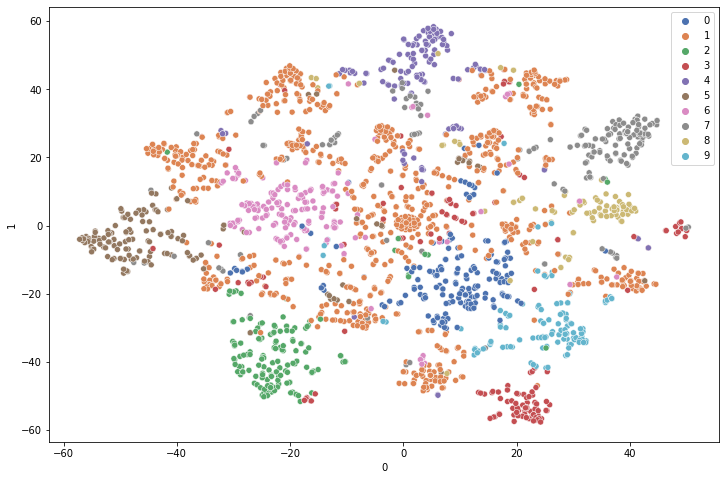

visualizer complete!


In [ ]:
make_topic_simliarity(ldamodel,corpus,20, 10)